Credits: https://github.com/Holmes-Alan/SIFT_ImgMatch/blob/main

Load required library

In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt

In [2]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

In [3]:
# Define a list of images you want to test

imageList = ["book1.jpg", "book2.jpg", "eiffel.jpg", "superman.jpg"]



In [4]:
# We use grayscale images for generating keypoints
imagesBW = []
for imageName in imageList:
    imagePath = str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale

In [5]:
# Using opencv's sift implementation here

sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

In [6]:
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + imageList[i])
    if imageList[i] == "book1.jpg":
        print("  Skipping image: " + imageList[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Ending for image: " + imageList[i])

Starting for image: book1.jpg
  Skipping image: book1.jpg
  Ending for image: book1.jpg
Starting for image: book2.jpg
  Ending for image: book2.jpg
Starting for image: eiffel.jpg
  Ending for image: eiffel.jpg
Starting for image: superman.jpg
  Ending for image: superman.jpg


In [7]:
for i, keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)

In [8]:
for i,descriptor in enumerate(descriptors):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)

**Task 1:** Define a reasonable threshold for the similarity between two image-keypoints

In [33]:
threshold = 0.75
def FilterMatches(matches, mode='selection'):
    '''
        Implements different options to filter matches.
            - 'sort' will simply sort them by similarity distance.
            - 'ratio' will employ the ratio test as in Lowe's paper
    '''
    if(mode == 'sort'):
        selection = sorted(matches, key = lambda x:x[0].distance)
    if(mode == 'ratio'):
        selection = [[m] for m, n in matches if m.distance < threshold*n.distance]

    return selection

Fetch Keypoints and Descriptors from stored files

In [22]:
def fetchKeypointFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

In [23]:
# Calculate Results for any pair
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    """
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults1.append([m])
    """
    topResults1 = FilterMatches(matches, mode='ratio')
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = FilterMatches(matches, mode='ratio')
    '''
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults2.append([m])
    '''
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

# scoring metric, a score greater than 10 means very good
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

# draw KNN matching plot
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        matchColor=[255, 0, 0],
        singlePointColor=[0, 255, 0],
        flags=0
    )
    return matchPlot

def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread(imageList[i]))
    image2 = imageResizeTest(cv2.imread(imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

# calculate matching results for any two images
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(f"Match paires: {len(matches)}, Keypoints in img1: {len(keypoint1)}, Keypoints in img2: {len(keypoint2)}")
    print(f"Matching score is: {score}%")
    plt.imshow(plot),plt.show()

Calculate the SIFT matches between images

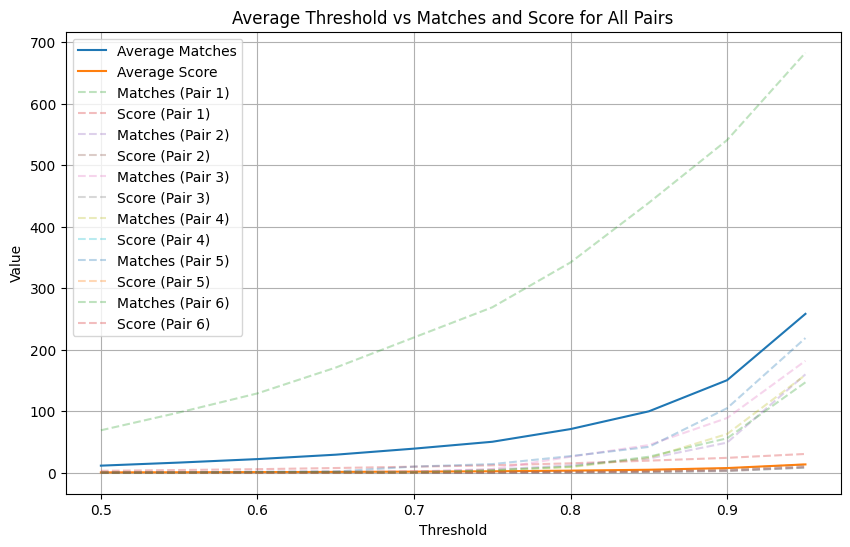

In [87]:
# THIS IS ALL THE CODE SINCE TASK 1 START. This is here so that it would make the plot quicker to make.
# To get individual results, please copy the code above the import "numpy as np" and "analyze_all_pairs" function. Then change threshold as needed.



threshold = 0.75
def FilterMatches(matches, mode='selection'):
    '''
        Implements different options to filter matches.
            - 'sort' will simply sort them by similarity distance.
            - 'ratio' will employ the ratio test as in Lowe's paper
    '''
    if(mode == 'sort'):
        selection = sorted(matches, key = lambda x:x[0].distance)
    if(mode == 'ratio'):
        selection = [[m] for m, n in matches if m.distance < threshold*n.distance]

    return selection
def fetchKeypointFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor
# Calculate Results for any pair
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    """
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults1.append([m])
    """
    topResults1 = FilterMatches(matches, mode='ratio')
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = FilterMatches(matches, mode='ratio')
    '''
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults2.append([m])
    '''
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

# scoring metric, a score greater than 10 means very good
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

# draw KNN matching plot
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        matchColor=[255, 0, 0],
        singlePointColor=[0, 255, 0],
        flags=0
    )
    return matchPlot

def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread(imageList[i]))
    image2 = imageResizeTest(cv2.imread(imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

# calculate matching results for any two images
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(f"Match paires: {len(matches)}, Keypoints in img1: {len(keypoint1)}, Keypoints in img2: {len(keypoint2)}")
    print(f"Matching score is: {score}%")
    plt.imshow(plot),plt.show()






# I will be making the plot to analyze the data more efficiently and get a more scientific result rather than just guessing the threshold value and assuming it to be correct.
import numpy as np

def analyze_all_pairs(threshold_range):
    global threshold # Set the threshold as global since it can't otherwise be used in this function.
    all_results = [] # Store results.
    pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)] # The pairs we will use to compare, this should cover everything.
    
    for pair in pairs: # Looping through the pairs
        results = [] # We try to find the best threshold for each pair and store it.
        for i in threshold_range: # Looping through each threshold.
            threshold = i # Set the threshold. This is why we made it global.
            
            matches = calculateMatches( # Get the matches.
                fetchDescriptorFromFile(pair[0]),
                fetchDescriptorFromFile(pair[1])
            )
            
            keypoints1 = fetchKeypointFromFile(pair[0])
            keypoints2 = fetchKeypointFromFile(pair[1])
            
            score = calculateScore(len(matches), len(keypoints1), len(keypoints2)) # Why we need this is explained in the plot function.
            
            results.append({ # Store these results so we could use them in a plot.
                'threshold': threshold,
                'matches': len(matches),
                'score': score
            })
        
        all_results.append(results)
    return all_results

def plot_averaged_results(all_results, threshold_range):
    avg_matches = []
    avg_scores = []
    
    for i in range(len(threshold_range)):
        total_matches = 0
        total_scores = 0
        for pair_results in all_results:
            total_matches += pair_results[i]['matches']
            total_scores += pair_results[i]['score']
        avg_matches.append(total_matches / len(all_results))
        avg_scores.append(total_scores / len(all_results))
    
    plt.figure(figsize=(10, 6)) # figure size is 10 X6
    plt.title('Average Threshold vs Matches and Score for All Pairs')
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.plot(threshold_range, avg_matches, label='Average Matches') # Plots average matches line. (What we are looking for)
    plt.plot(threshold_range, avg_scores, label='Average Score') # Plots average score line. (What we are looking for)
    plt.legend()
    plt.grid(True)
    
    # Add all the individual pairs to the plot as dotted lines. This is to show the variance and how we got the averages.
    for i in range(len(all_results)): # Loop through all possible pairs to get matches and scores. This was annoying to plot, and probably inefficient.
        matches = [result['matches'] for result in all_results[i]]
        scores = [result['score'] for result in all_results[i]]
        plt.plot(threshold_range, matches, alpha=0.3, linestyle='--', label=f'Matches (Pair {i+1})')
        plt.plot(threshold_range, scores, alpha=0.3, linestyle='--', label=f'Score (Pair {i+1})')
    
    plt.legend() # Hopefully its not too convoluted and doesn't glog everything up.
    plt.show()

# Finally, run the code and plot the results.
threshold_range = np.arange(0.5, 1.0, 0.05) # np.arange(start, stop, step). So, this will generate [0.5, 0.55, 0.6, 0.65, ..., 0.95].
all_results = analyze_all_pairs(threshold_range) 
plot_averaged_results(all_results, threshold_range)


### Print results and test thresholds for all the pairs like you would in calculateResultsFor(0,3). I commented this out so it wouldn't flood the area below. This is for curiosity.
#pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
#for i in [0.7, 0.75, 0.8]:
#    threshold = i
#    print(f"\nTesting threshold: {i}")
#    for pair in pairs:
#        print(f"Pair {pair}:")
#        calculateResultsFor(pair[0], pair[1])



Based on these findings from the plot, I'd say that 0.6 seems like the best candidate. While Pair 6 does skew the average, it seems that all the other pairs seem to share a similar trend of increasing more since 0.5 or 0.6. I'd personally go with 0.6 as it would yield more matches, while keeping a balance and not letting it overfit (or, rather, find false matches).

Match paires: 182, Keypoints in img1: 2236, Keypoints in img2: 1620
Matching score is: 11.234567901234568%


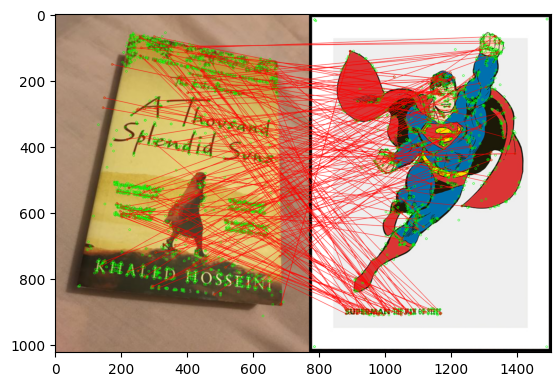

In [86]:
calculateResultsFor(0, 3) # calculate results for image 1 and image 4 (book1 and superman)
# Add tests between each image pair
# This is an example of how one can execute the code. I left it here as an example to run. This will not be used when completing the tasks.


**Task 2:** Redo the SIFT with all the images (including the 'book1_masked')

In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt

In [2]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

In [3]:
# Define a list of images you want to test

imageList = ["book1.jpg", "book2.jpg", "eiffel.jpg", "superman.jpg", "book1_masked.jpg"] # With added book1_masked.jpg for task 2



In [4]:
# We use grayscale images for generating keypoints
imagesBW = []
for imageName in imageList:
    imagePath = str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale

In [5]:
# Using opencv's sift implementation here

sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

In [6]:
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + imageList[i])
    if imageList[i] == "book1.jpg":
        print("  Skipping image: " + imageList[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Ending for image: " + imageList[i])

Starting for image: book1.jpg
  Skipping image: book1.jpg
  Ending for image: book1.jpg
Starting for image: book2.jpg
  Ending for image: book2.jpg
Starting for image: eiffel.jpg
  Ending for image: eiffel.jpg
Starting for image: superman.jpg
  Ending for image: superman.jpg
Starting for image: book1_masked.jpg
  Ending for image: book1_masked.jpg


In [7]:
for i, keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)

In [8]:
for i,descriptor in enumerate(descriptors):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)

In [15]:
threshold = 0.6
def FilterMatches(matches, mode='selection'):
    '''
        Implements different options to filter matches.
            - 'sort' will simply sort them by similarity distance.
            - 'ratio' will employ the ratio test as in Lowe's paper
    '''
    if(mode == 'sort'):
        selection = sorted(matches, key = lambda x:x[0].distance)
    if(mode == 'ratio'):
        selection = [[m] for m, n in matches if m.distance < threshold*n.distance]

    return selection
def fetchKeypointFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor
# Calculate Results for any pair
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    """
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults1.append([m])
    """
    topResults1 = FilterMatches(matches, mode='ratio')
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = FilterMatches(matches, mode='ratio')
    '''
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults2.append([m])
    '''
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

# scoring metric, a score greater than 10 means very good
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

# draw KNN matching plot
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        matchColor=[255, 0, 0],
        singlePointColor=[0, 255, 0],
        flags=0
    )
    return matchPlot

def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread(imageList[i]))
    image2 = imageResizeTest(cv2.imread(imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

# calculate matching results for any two images
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(f"Match paires: {len(matches)}, Keypoints in img1: {len(keypoint1)}, Keypoints in img2: {len(keypoint2)}")
    print(f"Matching score is: {score}%")
    plt.imshow(plot),plt.show()

We will now run the comparisons. For quicker results we will use a function.

Testing threshold: 0.6
Pair (0, 1):
Match paires: 129, Keypoints in img1: 2236, Keypoints in img2: 2342
Matching score is: 5.769230769230769%


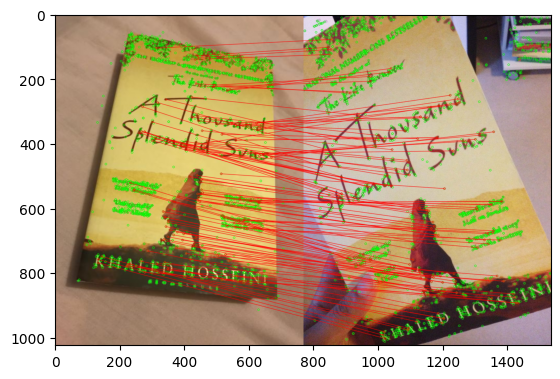

Pair (0, 2):
Match paires: 2, Keypoints in img1: 2236, Keypoints in img2: 1910
Matching score is: 0.10471204188481677%


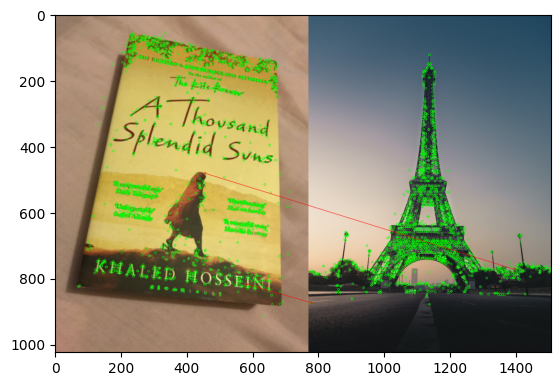

Pair (0, 3):
Match paires: 0, Keypoints in img1: 2236, Keypoints in img2: 1620
Matching score is: 0.0%


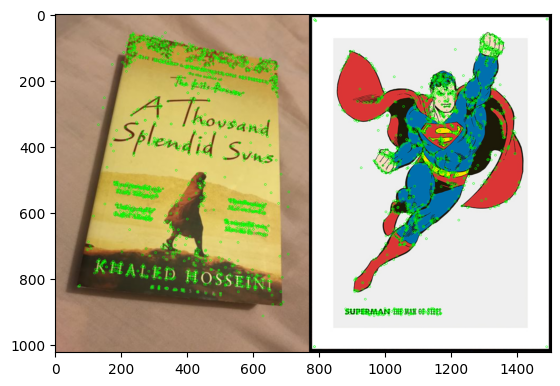

Pair (1, 2):
Match paires: 0, Keypoints in img1: 2342, Keypoints in img2: 1910
Matching score is: 0.0%


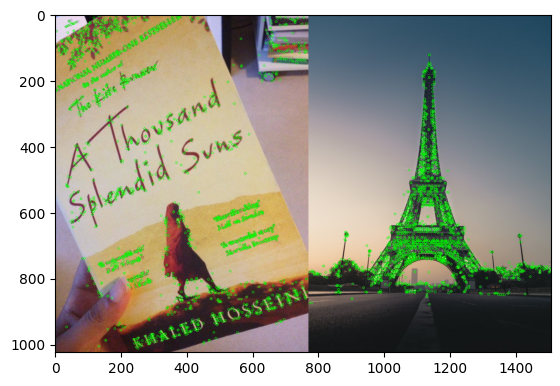

Pair (1, 3):
Match paires: 1, Keypoints in img1: 2342, Keypoints in img2: 1620
Matching score is: 0.06172839506172839%


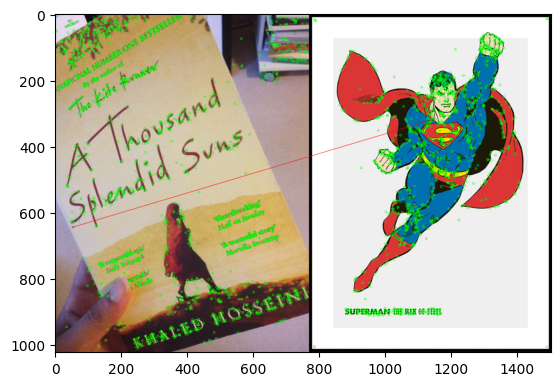

Pair (2, 3):
Match paires: 1, Keypoints in img1: 1910, Keypoints in img2: 1620
Matching score is: 0.06172839506172839%


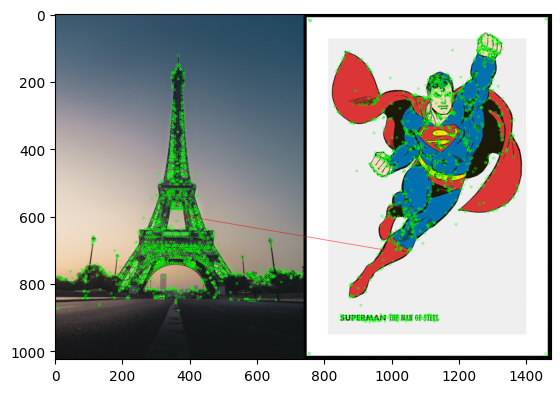

Pair (0, 4):
Match paires: 735, Keypoints in img1: 2236, Keypoints in img2: 3131
Matching score is: 32.87119856887299%


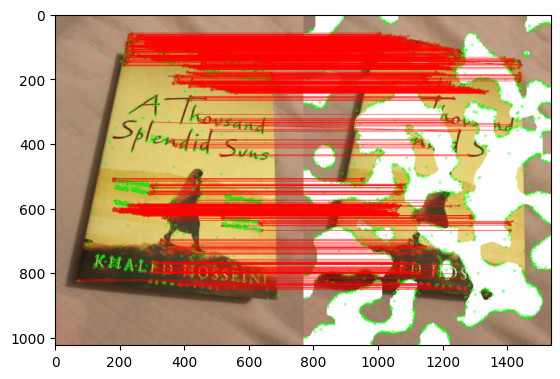

Pair (1, 4):
Match paires: 24, Keypoints in img1: 2342, Keypoints in img2: 3131
Matching score is: 1.0247651579846286%


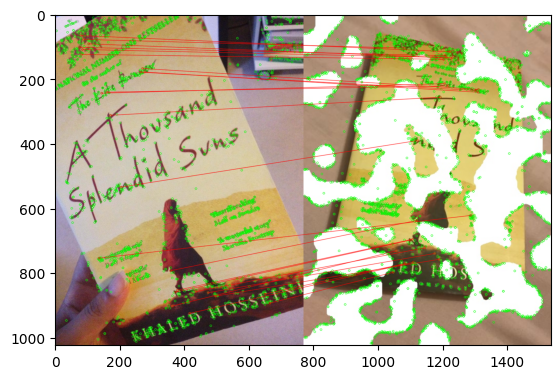

Pair (2, 4):
Match paires: 0, Keypoints in img1: 1910, Keypoints in img2: 3131
Matching score is: 0.0%


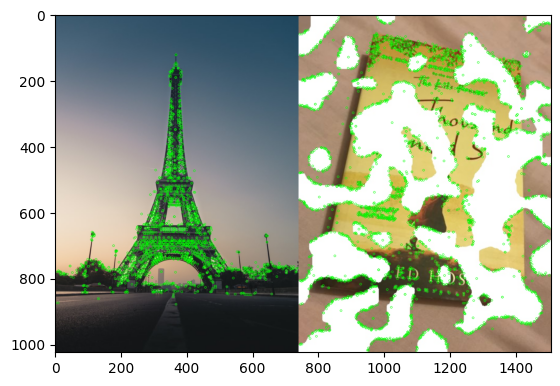

Pair (3, 4):
Match paires: 3, Keypoints in img1: 1620, Keypoints in img2: 3131
Matching score is: 0.1851851851851852%


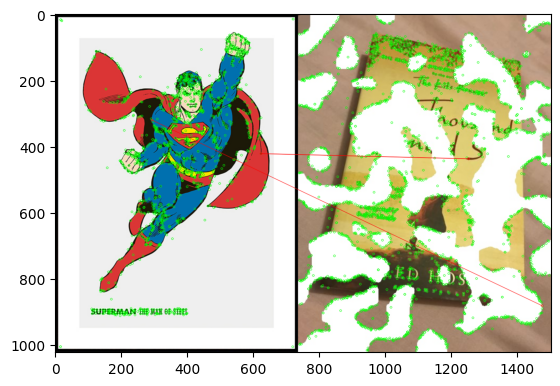

In [16]:
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (0, 4), (1, 4), (2, 4), (3, 4)] # Book1, Book2, Eiffel, Superman, Book1_masked. Book1_masked was added for task 2.
tested_threshold = 0.6
print(f"Testing threshold: {tested_threshold}")
for pair in pairs:
    print(f"Pair {pair}:")
    calculateResultsFor(pair[0], pair[1])

The findings: The image with book1 is kind of similar to the book2 image, but it clearly shows that the masked book is the same image (or is supposed to be) as book1. 35% was the finding. I'd say that by omitting the other results that are basically rounding errors, we can conclude that book1 is most likely the same as book1_masked.